# 🧨 Stable Diffusion in JAX / Flax !

We have created an experimental [JAX/Flax repo for Stable Diffusion](https://github.com/patil-suraj/stable-diffusion-jax). It will be merged into the 🤗 Hugging Face [Diffusers library](https://github.com/huggingface/diffusers) soon, but you can already use it with the just-released [Stable Diffusion weights](https://huggingface.co/CompVis/stable-diffusion-v1-4)!

This notebook focuses on JAX / Flax inference. If you want more details about how Stable Diffusion works or want to run it in GPU, please refer to [this Colab notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).

First, make sure you are using a TPU backend. If you are running this notebook in Colab, select `Runtime` in the menu above, then select the option "Change runtime type" and then select `TPU` under the `Hardware accelerator` setting.

**TODO**: screenshot.

The following cell makes sure that you are using a TPU to run this notebook. 

## Setup

In [11]:
import jax
num_devices = jax.device_count()
device_type = jax.devices()[0].device_kind

print(f"Found {num_devices} JAX devices of type {device_type}.")
assert device_type.startswith("TPU"), "Available device is not a TPU, please select TPU from Edit > Notebook settings > Hardware accelerator"

Found 8 JAX devices of type TPU v3.


We first install `stable-diffusion-jax`:

In [12]:
!pip install git+https://github.com/patil-suraj/stable-diffusion-jax

  Cloning https://github.com/patil-suraj/stable-diffusion-jax to /tmp/pip-req-build-tfmw4x5p
  Running command git clone --filter=blob:none --quiet https://github.com/patil-suraj/stable-diffusion-jax /tmp/pip-req-build-tfmw4x5p
  Resolved https://github.com/patil-suraj/stable-diffusion-jax to commit e4a2ea10e91d336feaa6ec73c4e4ed14842ce720
  Preparing metadata (setup.py) ... done
  Created wheel for stable-diffusion-jax: filename=stable_diffusion_jax-0.0.1-py3-none-any.whl size=20021 sha256=87f73834621f6683ca9fa762f2f5517baf52ce83689683106791e16db1646296
  Stored in directory: /tmp/pip-ephem-wheel-cache-tp89maph/wheels/3e/a0/c8/bb843ce7edc43ce2f9be6fb4ef6b32c34accbb6b3e130793d3
Successfully built stable-diffusion-jax


  Attempting uninstall: stable-diffusion-jax
    Found existing installation: stable-diffusion-jax 0.0.1
    Uninstalling stable-diffusion-jax-0.0.1:
      Successfully uninstalled stable-diffusion-jax-0.0.1


Then we import all the dependencies.

In [13]:
import jax
import jax.numpy as jnp
import numpy as np
from flax.jax_utils import replicate
from flax.training.common_utils import shard

from PIL import Image
from transformers import CLIPTokenizer, FlaxCLIPTextModel

In [14]:
from stable_diffusion_jax import (
    AutoencoderKL,
    InferenceState,
    PNDMScheduler,
    StableDiffusionPipeline,
    UNet2D
)

In order to use the model weights we first need to download them from the 🤗 Hugging Face Hub. We can use `git` with an authenticated user, like this:

**TODO**: 
- Push the flax models somewhere. CompVis?
- I don't think `subfolder` is supported in `FlaxPretrainedModel`, is it?

In [ ]:
!git lfs install
!git clone https://huggingface.co/fusing/sd-v1-4-flax

The following var points to the path that contains the weights we just downloaded.

In [20]:
flax_path = "sd-v1-4-flax"

## Model Loading

TPU devices support `bfloat16`, an efficient half-float type. We'll use it for our tests, but you can also use `float32` to use full precision instead.

**TODO**: Test quality impact, if any, when using float32.

In [15]:
dtype = jnp.bfloat16

The Stable Diffusion model, like Google's Imagen, uses a pre-trained CLIP model as a text encoder. We load it from OpenAI's official repository in 🤗 Hugging Face Hub.

In [16]:
clip_model, clip_params = FlaxCLIPTextModel.from_pretrained(
    "openai/clip-vit-large-patch14", _do_init=False, dtype=dtype
)

tcmalloc: large alloc 1710489600 bytes == 0x55e563012000 @  0x7f07d94b3680 0x7f07d94d4824 0x55e4d75d053b 0x55e4d76110ba 0x55e4d76e7a58 0x55e4d764348d 0x55e4d751d328 0x55e4d76fd66d 0x55e4d7643825 0x55e4d75a12da 0x55e4d7638fe3 0x55e4d763a709 0x55e4d75a073d 0x55e4d7638fe3 0x55e4d76e5a7c 0x55e4d7639dbb 0x55e4d771c33e 0x55e4d7643571 0x55e4d75a0088 0x55e4d762e7cb 0x55e4d767d0fc 0x55e4d762e7cb 0x55e4d767d0fc 0x55e4d762e7cb 0x55e4d7643f94 0x55e4d75a12da 0x55e4d7639be4 0x55e4d75a0088 0x55e4d7639be4 0x55e4d75a12da 0x55e4d7638fe3
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing FlaxCLIPTextModel: {('vision_model', 'encoder', 'layers', '23', 'layer_norm1', 'bias'), ('vision_model', 'encoder', 'layers', '8', 'self_attn', 'k_proj', 'bias'), ('vision_model', 'encoder', 'layers', '19', 'self_attn', 'out_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '0', 'self_attn', 'v_proj', 'bias'), ('vision_model', 'encoder', 'layers', '10', 'mlp', 'fc2

If you see a warning about a lot of missing layers, don't worry. It refers to the vision part of the CLIP model, that we will not be using here. We only need the text encoding capabilities of CLIP.

We'll also load the tokenizer that CLIP uses.

In [17]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

Now it's time to load the `unet` and `vae` (Autoencoder) models that are used during the Stable Diffusion process.

In [21]:
unet, unet_params = UNet2D.from_pretrained(f"{flax_path}/unet", _do_init=False, dtype=dtype)
vae, vae_params = AutoencoderKL.from_pretrained(f"{flax_path}/vae", _do_init=False, dtype=dtype)

tcmalloc: large alloc 3438108672 bytes == 0x55e5f4a06000 @  0x7f07d94b3680 0x7f07d94d4824 0x55e4d75d053b 0x55e4d76110ba 0x55e4d76e7a58 0x55e4d764348d 0x55e4d751d328 0x55e4d76fd66d 0x55e4d7643825 0x55e4d75a12da 0x55e4d7638fe3 0x55e4d763a709 0x55e4d75a073d 0x55e4d7638fe3 0x55e4d76e5a7c 0x55e4d7639dbb 0x55e4d771c33e 0x55e4d7643571 0x55e4d75a0088 0x55e4d762e7cb 0x55e4d767d0fc 0x55e4d762e7cb 0x55e4d767d0fc 0x55e4d762e7cb 0x55e4d7643f94 0x55e4d75a12da 0x55e4d7639be4 0x55e4d75a0088 0x55e4d7639be4 0x55e4d75a12da 0x55e4d7638fe3


Finally, we create a `PNSDMScheduler` to provide the noisy samples for the diffusion process.

In [22]:
scheduler = PNDMScheduler.from_config(flax_path)

## Inference

We define a couple of constants with the inference parameters we want to try out.

In [25]:
INFERENCE_STEPS = 50
GUIDANCE_SCALE = 7.5

Flax is a functional framework, so models are essentially stateless and parameters are stored outside the models. We create a helper state object and replicate it across all the available TPU devices. This will ensure inference is performed in parallel (one prompt per device), as we'll see later.

In [23]:
inference_state = InferenceState(text_encoder_params=clip_params, unet_params=unet_params, vae_params=vae_params)
inference_state = replicate(inference_state)

We now create the pipeline that plugs the models together. This is a Flax port of the official [diffusers implementation](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py).

In [24]:
pipe = StableDiffusionPipeline(text_encoder=clip_model, tokenizer=tokenizer, unet=unet, scheduler=scheduler, vae=vae)

JAX code can be compiled to an efficient representation that runs very fast. However, we need to ensure that all inputs need to have the same shape in subsequent calls; otherwise, JAX will have to compile the code again and we wouldn't be able to take advantage of the optimized speed.

`jax.pmap` does two things for us:
- Compiles (or `jit`s) the code, as if we had invoked `jax.jit()`.
- Ensures the compiled code runs in parallel in all the available devices.

We `pmap` the `pipe.sample` method, which is the one that generates images from input tokens. This way, every TPU device will receive a prompt and generate an image in parallel.

In [26]:
sample = jax.pmap(pipe.sample, static_broadcasted_argnums=(4, 5))

Taking advantage of parallelization, we prepare a list with the prompt we are interested in, repeated as many times as TPU devices we have. We then tokenize the list. In addition, we also tokenize a list with pad tokens. Both inputs are required to perform classifier-free guidance, as described [in this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb#scrollTo=yW14FA-tDQ5n).

In [50]:
num_samples = jax.device_count()

prompt = "A cinematic film still of Morgan Freeman starring as Jimi Hendrix, portrait, 40mm lens, shallow depth of field, close up, split lighting, cinematic"

input_ids = tokenizer(
    [prompt] * num_samples, padding="max_length", truncation=True, max_length=77, return_tensors="jax"
).input_ids
uncond_input_ids = tokenizer(
    [""] * num_samples, padding="max_length", truncation=True, max_length=77, return_tensors="jax"
).input_ids

key = jax.random.PRNGKey(42)

In [51]:
input_ids.shape, uncond_input_ids.shape

((8, 77), (8, 77))

The `shard` function prepares the input tensors such as each device receives one item from `input_ids` and one item from `uncond_input_ids`. We also split the random number generator key so each device receives a different one, so generation starts from a different random state. Therefore, generated images will be different.

In [52]:
input_ids = shard(input_ids)
uncond_input_ids = shard(uncond_input_ids)
keys = jax.random.split(key, jax.device_count())

In [53]:
input_ids.shape, uncond_input_ids.shape

((8, 1, 77), (8, 1, 77))

We are now ready to generate images! Remember that `sample()` refers to a parallelized version of `pipe.sample`, so the following code will run 8 copies of the pipeline – one per device.

The first time we run the function it will take a long time to compile. For example, it took about `90s` to compile in a TPU v3-8 when I tested. But if we run it again (even with different inputs), it will be much faster!

In [57]:
def predict(input_ids, uncond_input_ids, keys):    
    images = sample(
        input_ids,
        uncond_input_ids,
        keys,
        inference_state,
        INFERENCE_STEPS,
        GUIDANCE_SCALE,
    )

    # Prepare keys for next generation
    keys = jax.random.split(keys[-1], jax.device_count())
    return images, keys

In [58]:
images, keys = predict(input_ids, uncond_input_ids, keys)

`images` is a tensor that contains the `8` images generated by the TPU devices:

In [60]:
images.shape

(8, 1, 512, 512, 3)

## Visualization

Let's create a couple of helper functions to:
- Convert the image tensor to PIL images.
- Visualize them in a grid.

In [62]:
def images_to_pil(images):
    images = images / 2 + 0.5
    images = jnp.clip(images, 0, 1)
    images = (images * 255).round().astype("uint8")
    images = np.asarray(images).reshape((num_samples, 512, 512, 3))

    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [63]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

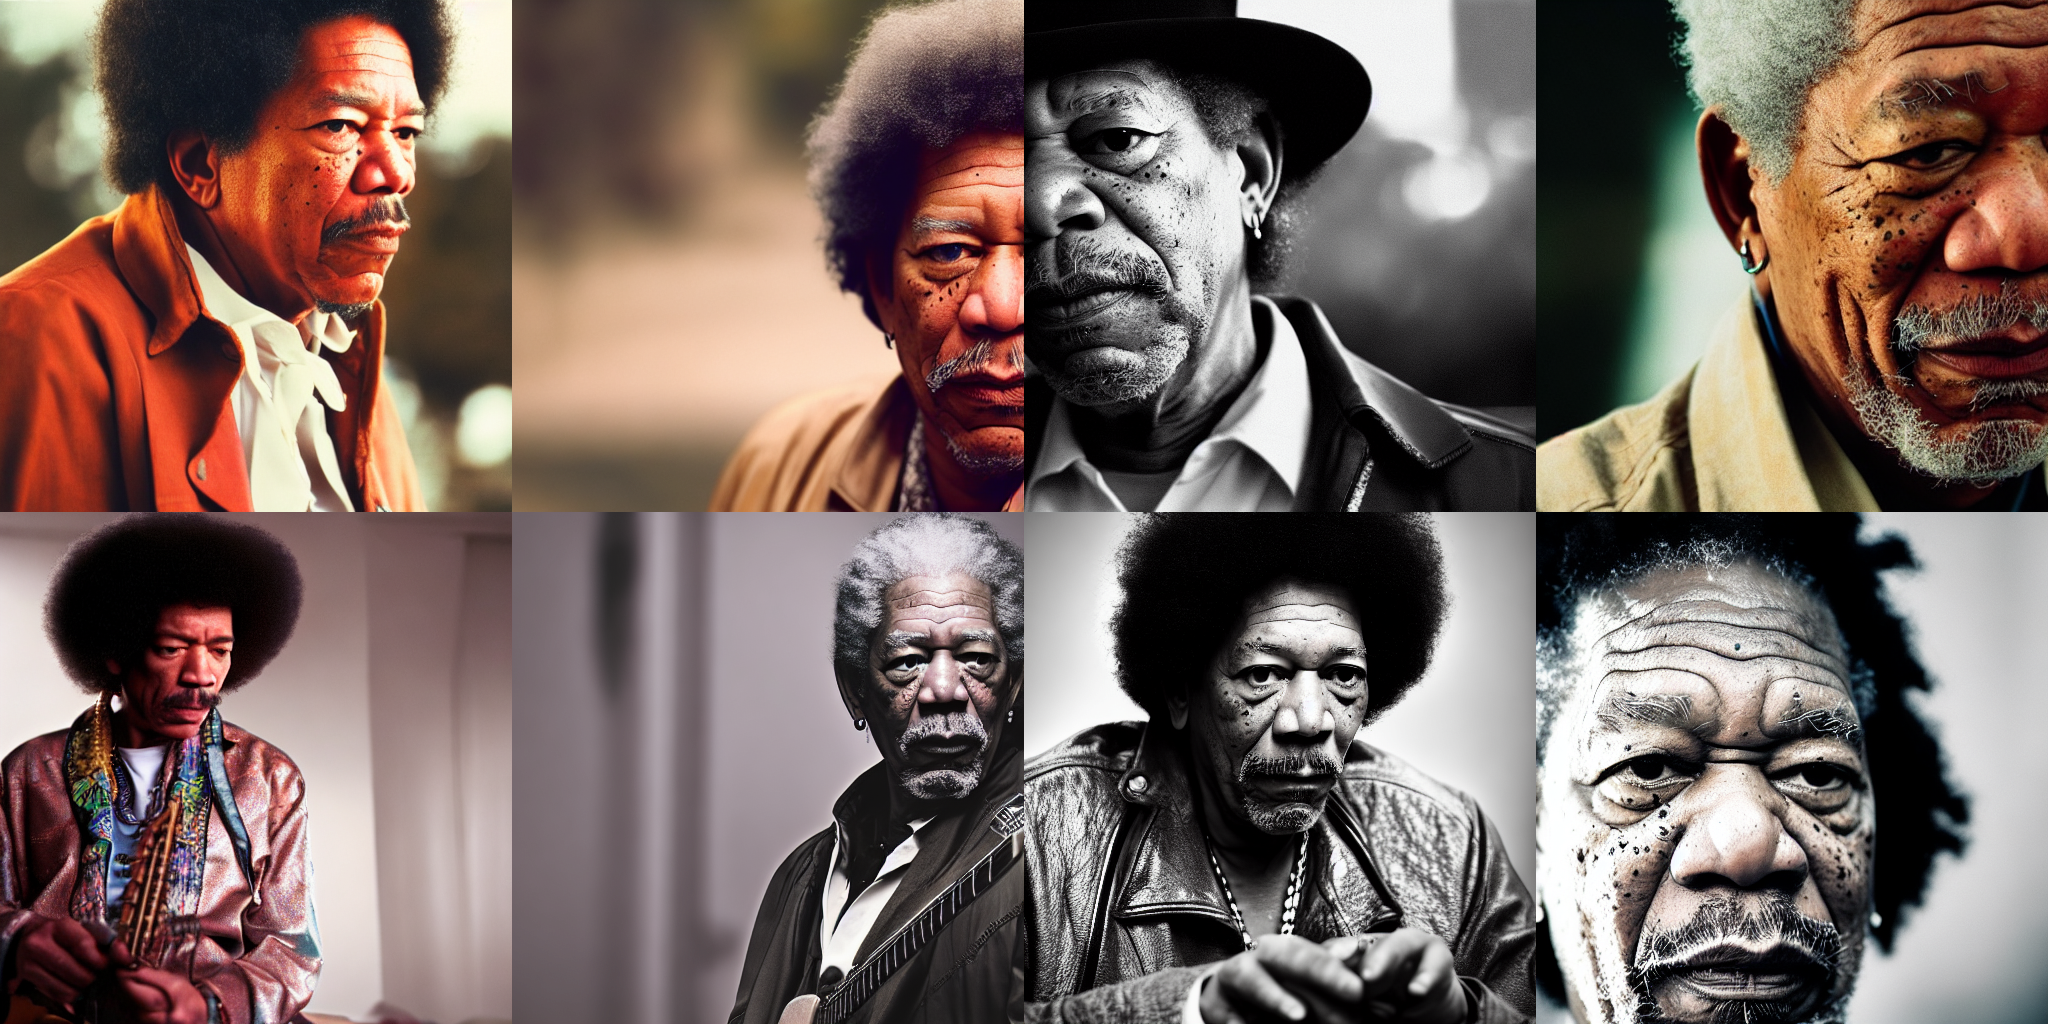

In [66]:
image_grid(images_to_pil(images), 2, 4)

## Using different prompts

We don't have to replicate the _same_ prompt in all the devices. We can do whatever we want: generate 2 prompts 4 times each, or even generate 8 different prompts at once. Let's do that!

First, we'll refactor the input preparation code into a handy function:

In [74]:
def get_input_ids(prompts):
    # For simplicity, we require that the `prompts` is a list with as many items as devices
    # We could compute the number of required repetitions ourselves; i.e., sending 2 prompts would repeat 4 times each.
    num_samples = jax.device_count()
    assert num_samples == len(prompts), f"Please, prepare your prompts as list of {num_samples} strings."

    input_ids = tokenizer(
        prompts, padding="max_length", truncation=True, max_length=77, return_tensors="jax"
    ).input_ids
    
    uncond_input_ids = tokenizer(
        [""] * num_samples, padding="max_length", truncation=True, max_length=77, return_tensors="jax"
    ).input_ids
    
    return {
        "input_ids": shard(input_ids),
        "uncond_input_ids": shard(uncond_input_ids),
    }

In [68]:
prompts = [
    "Labrador in the style of Hokusai",
    "Painting of a squirrel eating a hamburger",
    "HAL-9000 in the style of Van Gogh",
    "Times Square under water, with fish and a dolphin swimming around",
    "Ancient Roman fresco showing a man working on his laptop",
    "Close-up photograph of young black woman against urban background, high quality, bokeh",
    "Armchair in the shape of an avocado",
    "Clown astronaut in space, with Earth in the background",
]

In [75]:
inputs = get_input_ids(prompts)

In [77]:
images, keys = predict(inputs["input_ids"], inputs["uncond_input_ids"], keys)

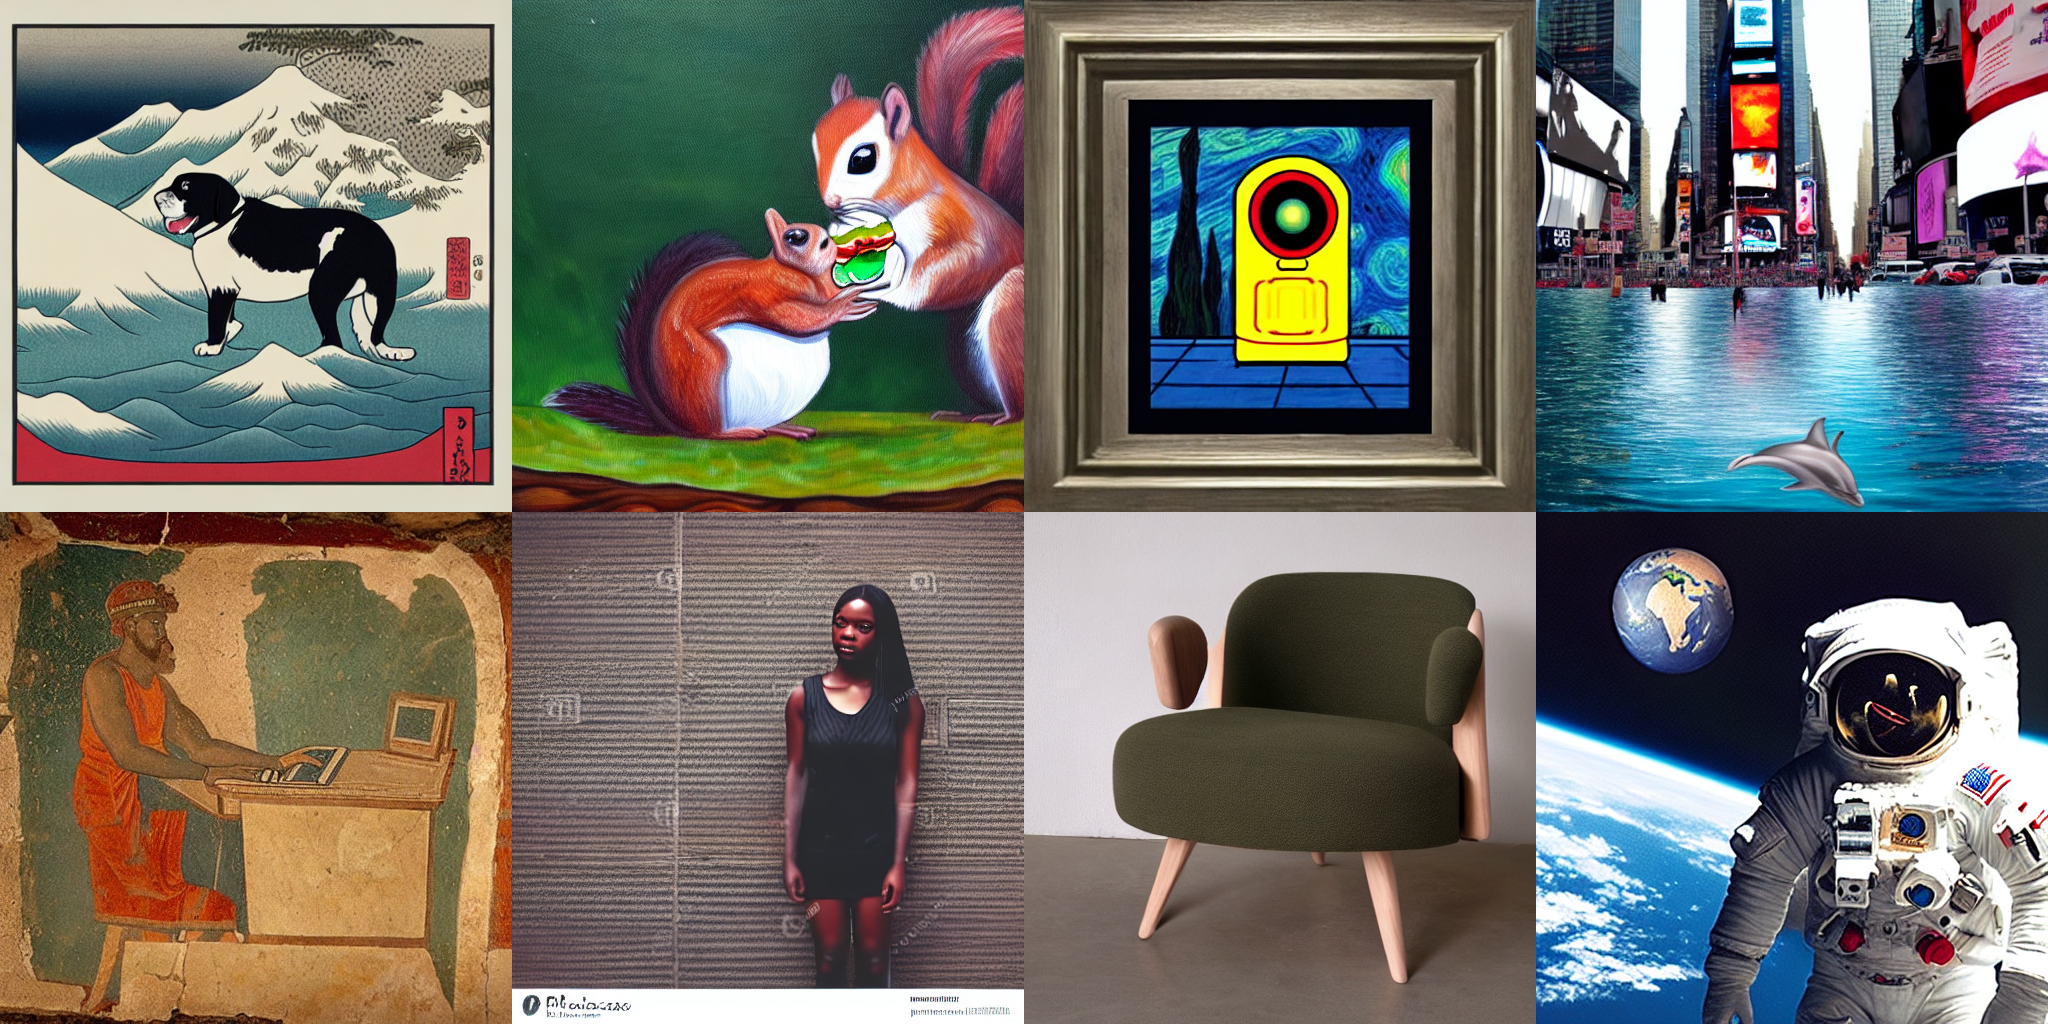

In [78]:
image_grid(images_to_pil(images), 2, 4)